# Batching and Distributed Training / Evaluation

In this demo, we will go through batched training and distributed training across multiple models. These models could live on independent GPUs, which would accelerate the training and evaluation time; however, for the sake of this example, they will all live on the CPU. This will follow the general principles of *data parallelism*, where we make an identical copy of the model and feed different splits of the data to each model to run in parallel.

This mode is important when the dataset is so large that it either cannot fit in memory at one time, or the model overhead plus the data is too large for a single machine. In order to make identical gradient updates to a full-dataset optimization, we can *accumulate* (or sum) the gradients computed with different non-overlapping subsets of the data, which allows us to train the model on a dataset that exceeds the size of the memory capacity of the machine.

We also demonstrate disk-based data streaming for lazy I/O when the raw data is too large to store in memory. This is used in tandem with minibatching.

**Note 1**: Throughout this tutorial we assume that all models live on the same node, even if they are on different devices (e.g. GPUs). This is analogous to a multi-GPU node where all GPUs can communicate directly with each other, and are aware of each other. Multi-node distributed training will be the subject of a different tutorial.

**Note 2**: See pytorch `DataParallel` or `DistributedDataParallel` (DDP) for some other examples of multi-GPU training. One could use DDP to do what we describe below, which will be incorporated in the future `BayesLIM` releases, but for now we use something homegrown that is a simpler but may be less efficient than Pytorch DDP.

Dated: July 2025

# 1. Setting up the problem

We will use a mock dataset that can indeed fit in memory, but will use it to demonstrate the techniques one can use to scale up the training to a larger dataset.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import bayeslim as ba
import copy

torch.set_default_dtype(torch.float64)

In [2]:
print("numpy version:", np.__version__)
print("BayesLIM version:", ba.__version__)
print("pytorch version:", torch.__version__)

numpy version: 1.26.3
BayesLIM version: 0.0.1
pytorch version: 2.2.1


In [3]:
# setup observing frequencies: 20 channels
freqs = torch.linspace(120e6, 130e6, 20)
Nfreqs = len(freqs)

# setup observing times: 40 times
times = torch.linspace(2458148.15, 2458148.25, 40)
Ntimes = len(times)

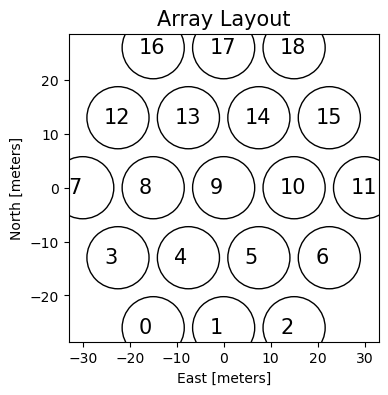

In [4]:
# setup telescope array: antenna numbers and antenna vectors in [X,Y,Z] (meters)
ants, antvecs = ba.utils._make_hex(3)

plt.figure(figsize=(4,4))
plt.scatter(*antvecs[:, :2].T, s=2000, ec='k', fc='none')
for ant, antvec in zip(ants, antvecs):
    plt.text(antvec[0]-3, antvec[1]-1, ant, fontsize=15)
plt.title('Array Layout', fontsize=15)
plt.xlabel('East [meters]'); plt.ylabel('North [meters]');

In [5]:
# create an Array object
antpos_dict = dict(zip(ants, antvecs))
array = ba.telescope_model.ArrayModel(antpos_dict, freqs=freqs)

/Users/nkern/anaconda3/envs/py311/lib/python3.11/site-packages/bayeslim/utils.py:2220: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/utils/tensor_new.cpp:278.)
  self.antvecs = torch.as_tensor(antvecs)


In [6]:
# create the telescope: (longitude, latitude) in degrees, altitude [m]
telescope = ba.telescope_model.TelescopeModel((21.42827, -30.72148, 1051.69))

In [7]:
# given the telescope model, print out the LSTs of the observing times
lsts = ba.telescope_model.JD2LST(times, telescope.location[0])
# get lsts from radians -> hour angle
lsts = np.unwrap(lsts) * 12 / np.pi
print("LST range {:.2f} -- {:.2f} hours".format(lsts[0], lsts[-1]))

LST range 1.62 -- 4.02 hours


Next let's create a RIME model. It doesn't really matter how we do this for now, just that this is a forward model that will produce an estimate of a set of radio interferometric visibilities. This borrows from the `beam_fg_demo.ipynb` tutorial.

### Gaussian Beam Model

In [8]:
# make the beam response function with two free parameters: East-West and North-South width
R = ba.beam_model.GaussResponse()

# the beam parameter should have shape: (Npol, Nvec, Nmodel, Nfreqs, 2)
# where the last dimension is (EW, NS) respectively
beam_params = torch.ones(1, 1, 1, Nfreqs, 2)
beam_params[..., :, 0] = torch.linspace(.25, .30, Nfreqs) # east-west
beam_params[..., :, 1] = torch.linspace(.20, .25, Nfreqs) # north-south

# make the beam model: parameter=True makes the beam_params differentiable in the graph
# we have to specify a feed polarization, but it is arbitrary
beam_model = ba.beam_model.PixelBeam(beam_params.clone(), freqs, R=R, parameter=True, name='beam', pol='e')

### Point Source Model

In [9]:
# populate 1000 point sources randomly on the sky across 5 hours of RA
# note: this quasi-uniform distribution technically assumes a flat-sky approximation
torch.manual_seed(6)
ra = torch.rand(1000) * 5 * 15        # in degrees
dec = (torch.rand(1000)-.5) * 80 -30.72 # in degrees
fluxes = torch.randn(1000)              # log-normal fluxes
spix = torch.randn(1000) * .1 - 2.2     # gaussian spix centered at -2.2

In [10]:
# generate a response function for the point sources in the form of a log-powerlaw
# set the powerlaw anchor frequency (f0) as the zeroth freq channel
R = ba.sky_model.PointSkyResponse(freqs, freq_mode='powerlaw', log=True, f0=freqs[:1])

# sky_params.shape = (Nstokes, 1, 2, Nsources)
sky_params = torch.stack([fluxes, spix])[None, None, :, :]
sky_angs = torch.stack([ra, dec])
sky_model = ba.sky_model.PointSky(sky_params.clone(), sky_angs, R=R, name='sky', parameter=True)

### Setup the RIME model

In [11]:
# get the simulated baseline list
sim_bls = array.get_bls(uniq_bls=True, keep_autos=False)
print("Nbls : {}".format(len(sim_bls)))

Nbls : 30


In [12]:
# instantiate the RIME: make copy of some objects that use a cache
rime = ba.rime_model.RIME(
    sky_model,
    copy.deepcopy(telescope),
    beam_model,
    copy.deepcopy(array),
    sim_bls,
    times,
    freqs
)
print(rime)

RIME(
  (sky): PointSky()
  (beam): PixelBeam()
  (array): ArrayModel()
)


Okay, so now we have a standard RIME object that will forward model the sky and instrument parameters to a set of visibilities. Let's just look at this.

In [13]:
with torch.no_grad():
    vis = rime()
    
print("Npol={}, Nbls={}, Ntimes={}, Nfreqs={}".format(*vis.data.shape[1:]))

Npol=1, Nbls=30, Ntimes=40, Nfreqs=20


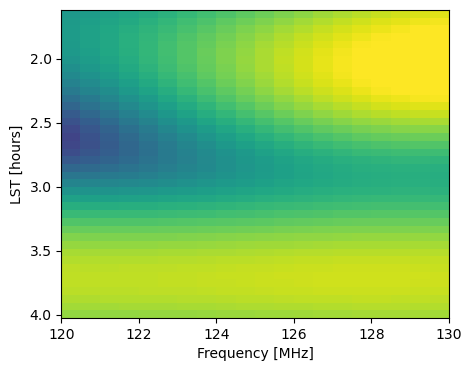

In [14]:
# plot the visibility
plt.figure(figsize=(5, 4))
plt.imshow(vis[(0, 1)].abs(), aspect='auto', extent=[freqs[0]/1e6,freqs[-1]/1e6,lsts[-1],lsts[0]], vmin=0, vmax=35)
plt.xlabel('Frequency [MHz]'); plt.ylabel('LST [hours]');

This is fairly small in memory, but let's assume for a minute that it wasn't. Or, all the same, we can assume that running a RIME and storing the computational graph for this amount of data exceeded our machine's memory. This is often the case when using a diffuse pixelized sky model, which requires a new copy of the sky fringe (in topocentric coordinates) for every single time integration. Thus, we might want to split the forward and backward computation up into smaller chunks instead of a single pass with all Ntimes time integrations. The same can be said about the number of baselines.

Before we look at how to create (mini)batches of data to operate on, let's finish creating the `LogProb` object responsible for computing the posterior and performing the gradient calculation via reverse-mode backpropagation.

In [15]:
# now let's create the log-posterior

# add some noise to the data to make the raw_data
torch.manual_seed(0)
raw_vis = vis + torch.randn_like(vis.data)
target = ba.dataset.Dataset(raw_vis)

prob = ba.optim.LogProb(rime, target)

print(prob)

LogProb(
  (model): RIME(
    (sky): PointSky()
    (beam): PixelBeam()
    (array): ArrayModel()
  )
)


In [16]:
# let's just run backprop for the whole dataset (all of entries in target)
prob.closure()
grads = (sky_model.params.grad.clone(), beam_model.params.grad.clone())

In [17]:
# print some elements of the gradients
print(grads[0].ravel()[:3], grads[1].ravel()[:3])

tensor([-23.1341, -18.5615, -53.9607]) tensor([ 1922.1561,  1176.8896, -2565.6212])


# 2. (Mini)batching and gradient accumulation

Note that the `bayeslim.dataset.Dataset` object can be fed sub-batches as a list, which defines how the data are batched.
The `LogProb` object has specific functionality for operating on these sub-batches, provided in the `LogProb.batch_idx()`, and `LogProb.get_batch_data()` methods.

The BayesLIM `RIME` object interfaces with this API along two dimensions: Nbaselines and Ntimes. Thus, we can define minibatches along these dimensions and the `RIME` will handle it automatically. Note that here we are only defining sub-batches of the data to run on for each forward pass, and haven't yet tackled distributed, multi-device evaluation (next).

In [18]:
# define 3 time_groups for RIME batching
time_groups = ba.utils.split_into_groups(times, Ngroup=3)
Ntime_groups = len(time_groups)
print(time_groups)

[tensor([2458148.1500, 2458148.1526, 2458148.1551, 2458148.1577, 2458148.1603,
        2458148.1628, 2458148.1654, 2458148.1679, 2458148.1705, 2458148.1731,
        2458148.1756, 2458148.1782, 2458148.1808, 2458148.1833]), tensor([2458148.1859, 2458148.1885, 2458148.1910, 2458148.1936, 2458148.1962,
        2458148.1987, 2458148.2013, 2458148.2038, 2458148.2064, 2458148.2090,
        2458148.2115, 2458148.2141, 2458148.2167, 2458148.2192]), tensor([2458148.2218, 2458148.2244, 2458148.2269, 2458148.2295, 2458148.2321,
        2458148.2346, 2458148.2372, 2458148.2397, 2458148.2423, 2458148.2449,
        2458148.2474, 2458148.2500])]


In [19]:
# now split the raw_data along these dimensions
batched_targets = []
for tg in time_groups:
    batched_targets.append(raw_vis.select(times=tg, inplace=False))
    
batched_targets = ba.dataset.Dataset(batched_targets)

In [20]:
# confirm Ntimes is split
for i, tg in enumerate(time_groups):
    print("Ntimes={}, target_batch {} shape={}".format(len(tg), i, batched_targets[i].data.shape))

Ntimes=14, target_batch 0 shape=torch.Size([1, 1, 30, 14, 20])
Ntimes=14, target_batch 1 shape=torch.Size([1, 1, 30, 14, 20])
Ntimes=12, target_batch 2 shape=torch.Size([1, 1, 30, 12, 20])


In [21]:
# now let's put these time batches into RIME
rime.setup_sim_times(time_groups)

Now we can confirm this was setup in the RIME object, and we can see or change which batch index it is currently computing. The default batch_idx is 0 upon instantiation.

In [22]:
# now let's confirm these batches are in place
print("rime Nbatches = {}".format(rime.Nbatch))
print("current batch_idx = {}".format(rime.batch_idx))
print("current sim_times: {}".format(rime.sim_times))

rime Nbatches = 3
current batch_idx = 0
current sim_times: [2458148.15       2458148.1525641  2458148.15512821 2458148.15769231
 2458148.16025641 2458148.16282051 2458148.16538462 2458148.16794872
 2458148.17051282 2458148.17307692 2458148.17564103 2458148.17820513
 2458148.18076923 2458148.18333333]


In [23]:
# now let's change the batch index and confirm it matches expectation
rime.batch_idx = 1

print("rime Nbatches = {}".format(rime.Nbatch))
print("current batch_idx = {}".format(rime.batch_idx))
print("current sim_times: {}".format(rime.sim_times))

rime Nbatches = 3
current batch_idx = 1
current sim_times: [2458148.18589744 2458148.18846154 2458148.19102564 2458148.19358974
 2458148.19615385 2458148.19871795 2458148.20128205 2458148.20384615
 2458148.20641026 2458148.20897436 2458148.21153846 2458148.21410256
 2458148.21666667 2458148.21923077]


In [24]:
# now if we run rime it will only compute the visibilities for this batch
with torch.no_grad():
    rime.batch_idx = 1
    batch_vis = rime()
    
print("Npol={}, Nbls={}, Ntimes={}, Nfreqs={}".format(*batch_vis.data.shape[1:]))

Npol=1, Nbls=30, Ntimes=14, Nfreqs=20


In [25]:
# assert the simulated visibility times are the same as expected given the time batch
batch_vis.times - time_groups[rime.batch_idx]  # should be zeros

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

To get all of the batches evaluated (e.g. for inspection purposes), you can cycle through each batch and then concatenate the VisData objects (depending on how you batched them to begin with).

In [26]:
batch_vis = []
for i in range(rime.Nbatch):
    rime.batch_idx = i
    with torch.no_grad():
        batch_vis.append(rime())

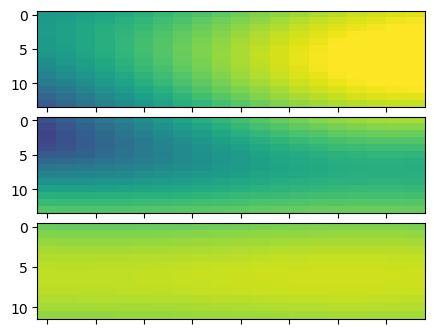

In [27]:
fig, axes = plt.subplots(len(batch_vis), 1, figsize=(5, 4))
fig.subplots_adjust(hspace=.1)
for i, ax in enumerate(axes):
    ax.imshow(batch_vis[i][(0, 1)].abs(), aspect='auto', vmin=0, vmax=35)
    ax.set_xticklabels([])

In [28]:
# now concatenate them along the time axis into a single VisData object
batch_vis = ba.dataset.concat_VisData(batch_vis, 'time')
print("Npol={}, Nbls={}, Ntimes={}, Nfreqs={}".format(*batch_vis.data.shape[1:]))

Npol=1, Nbls=30, Ntimes=40, Nfreqs=20


Note this can also be done automatically with a helper function:

In [29]:
with torch.no_grad():
    batch_vis = rime.run_batches(concat=True)
    
print("Npol={}, Nbls={}, Ntimes={}, Nfreqs={}".format(*batch_vis.data.shape[1:]))

Npol=1, Nbls=30, Ntimes=40, Nfreqs=20


Okay, now let's incorporate this into the `LogProb` object. Here we will specify how the object will accumulate the gradients. If we select 'accumulate' (default), then the `prob.closure()` method will iterate over all batches and sum the gradients. Otherwise, `prob.closure()` will only run the gradient for the current batch index.

In [30]:
prob = ba.optim.LogProb(rime, batched_targets, grad_type='accumulate')

print(prob)
print("prob.Nbatch = {}".format(prob.Nbatch))
print("prob.batch_idx = {}".format(prob.batch_idx))

LogProb(
  (model): RIME(
    (sky): PointSky()
    (beam): PixelBeam()
    (array): ArrayModel()
  )
)
prob.Nbatch = 3
prob.batch_idx = 0


Let's compute the gradients again but this time over each minibatch separately and then summing them together (compare to the previous "full-batch" case from above).

In [31]:
# let's just run backprop for the whole dataset (all of entries in target)
prob.closure()
print("Gradients with minibatching and gradient accumulation:")
print(sky_model.params.grad.ravel()[:3], beam_model.params.grad.ravel()[:3])

Gradients with minibatching and gradient accumulation:
tensor([-23.1341, -18.5615, -53.9607]) tensor([ 1922.1561,  1176.8896, -2565.6212])


Note, one can do the same minibatching along the baseline axis with `rime.setup_sim_bls`, which can also be done in conjunction with time-based minibatching.

# 3. Lazy I/O

Minibatching is useful when building the computational graph for a given dataset is too large to store in memory, but it is also useful when the data itself is too large to store in memory. Here, we show how to use lazy I/O to automatically stream data from disk into memory while using the same normal BayesLIM training API. The key difference is simply in how we load the data into a `VisData` object. Currently, lazy I/O is only supported for `VisData`, and the data must already be chunked on disk according to the chosen minibatch split.

In [32]:
from tempfile import TemporaryDirectory

In [33]:
with TemporaryDirectory() as tmp:
    # first write the batched targets to disk
    # then re-load them with lazy_load
    batched_lazy_targets = []
    for i, tgt in enumerate(batched_targets):
        tgt.write_hdf5(tmp + "/raw_vis{}.h5".format(i))
        
        lazy_target = ba.VisData()
        lazy_target.read_hdf5(tmp + "/raw_vis{}.h5".format(i), lazy_load=True)
        batched_lazy_targets.append(lazy_target)
        
    # confirm that the data is not loaded into the lazy_targets, just the HDF5 handle
    print("lazy_target.data is the HDF5 handle: {}\n".format(lazy_target.data))
    
    # now make the LogProb object
    prob = ba.optim.LogProb(rime, ba.dataset.Dataset(batched_lazy_targets), grad_type='accumulate')

    # now compute gradients
    prob.closure()
    print('Gradients with batching and lazy I/O:')
    print(sky_model.params.grad.ravel()[:3], beam_model.params.grad.ravel()[:3])

lazy_target.data is the HDF5 handle: <HDF5 dataset "data": shape (1, 1, 30, 12, 20), type "<c16">

Gradients with batching and lazy I/O:
tensor([-23.1341, -18.5615, -53.9607]) tensor([ 1922.1561,  1176.8896, -2565.6212])


# 4. Data parallel training and evaluation

Now we are prepared to look at how this can be done in a distributed manner across multiple devices. Due to the limitations with the notebook, we will keep these all on the CPU (and thus will get no performance boost), but we show how to distribute this across multiple GPUs when available, which will parallelize the forward and backward call amongst the provided GPUs.

In the data parallel paradigm, we copy the entire model to each device and simply run on a subset of the data for each device, and then sum the gradients before making an identical parameter update for the model on every device. In this example, we will simply give each model its own minibatch. One could, however, additionally give each model its own set of minibatches on the subset of data it is given.

To do this, one must use the `prob.set_main_params()` feature to collect all tunable parameters into a single tensor that will be passed between devices.

In [34]:
# specify devices for each minibatch

#devices = ['cuda:0', 'cuda:1', 'cuda:2']
devices = ['cpu', 'cpu', 'cpu']

In [35]:
# instantiate the RIME: make copy of some objects that use a cache
rime = ba.rime_model.RIME(
    sky_model,
    copy.deepcopy(telescope),
    beam_model,
    copy.deepcopy(array),
    sim_bls,
    times,
    freqs
)
print(rime)

RIME(
  (sky): PointSky()
  (beam): PixelBeam()
  (array): ArrayModel()
)


In [36]:
# setup a new RIME model for each device
probs = []
for i, device in enumerate(devices):
    model = copy.deepcopy(rime)
    model.setup_sim_times(time_groups[i])
    model.push(device)
    _target = batched_targets[i]
    _target.push(device)
    prob = ba.optim.LogProb(
        model,
        ba.dataset.Dataset(_target),
        device=device)
    probs.append(prob)

In [37]:
# setup the master distributed object
# this keeps a copy of "main_params" 
dprob = ba.optim.DistributedLogProb(probs, check=False)

In [38]:
# now use the set_main_params feature to collect all tunable parameters
# this is automatically propagated to all the "prob" objects on each device
dprob.set_main_params(model_params=['sky.params', 'beam.params'])

In [39]:
# now use the closure method on dprob to compute gradients on each device, and then send them
# back to the dprob object
dprob.closure();

In [40]:
# print gradients like before
print("Distributed minibatch gradients:")
print(dprob.main_params.grad[dprob._main_indices['sky.params']][:3].cpu(),
      dprob.main_params.grad[dprob._main_indices['beam.params']][:3].cpu())

Distributed minibatch gradients:
tensor([-23.1341, -18.5615, -53.9607]) tensor([ 1922.1561,  1176.8896, -2565.6212])


Note that as written this won't incur a speed-up because all of our models are on the same device, but if one has multiple GPUs available, one can get a speed-up. This speed-up generally wont be a factor of Ndevices, as there is still overhead and communication, but it should still be an improvement.

One is likely to get even more improvement (and better Ndevice scaling) by wrapping this is pytorch's DistributedDataParallel.